In [ ]:
# baseline + multi step forecast

In [82]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
import  numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

/var/folders/6g/0jt3knmj2hj4lmvq8xkclwc80000gn/T/ipykernel_41929/327614872.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()


In [203]:
import pandas as pd
ts_ms = pd.date_range(start = '2023-03-10 06:13:20',     # 날짜 범위 시작
                     end = None,                # 날짜 범위 끝
                     periods = 19304,               # 생성할 Timestamp 개수
                     freq = '0.5T',               # 시간 간격(MS : 월의 시작일)
                     tz = 'Asia/Seoul')         # 시간대(timezone)
print(ts_ms)

DatetimeIndex(['2023-03-10 06:13:20+09:00', '2023-03-10 06:13:50+09:00',
               '2023-03-10 06:14:20+09:00', '2023-03-10 06:14:50+09:00',
               '2023-03-10 06:15:20+09:00', '2023-03-10 06:15:50+09:00',
               '2023-03-10 06:16:20+09:00', '2023-03-10 06:16:50+09:00',
               '2023-03-10 06:17:20+09:00', '2023-03-10 06:17:50+09:00',
               ...
               '2023-03-16 23:00:20+09:00', '2023-03-16 23:00:50+09:00',
               '2023-03-16 23:01:20+09:00', '2023-03-16 23:01:50+09:00',
               '2023-03-16 23:02:20+09:00', '2023-03-16 23:02:50+09:00',
               '2023-03-16 23:03:20+09:00', '2023-03-16 23:03:50+09:00',
               '2023-03-16 23:04:20+09:00', '2023-03-16 23:04:50+09:00'],
              dtype='datetime64[ns, Asia/Seoul]', length=19304, freq='30S')


In [222]:
# load dataset
series = {}
series = read_csv('../data/cpu_memory_usage_v1.csv') # 12개의 pod
series
series = series.loc[series.pod_name == 'drive-az2-prd-69cbb999bc-st442']
series['time'] = ts_ms
series.set_index('time', inplace=True)
series = series.loc[:,['memory_working_set_bytes']]
series
series.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
memory_working_set_bytes,19304.0,1.288949e+09,4.584802e+07,1.210601e+09,1.263063e+09,1.284686e+09,1.307138e+09,2.417492e+09


In [212]:
series_plot = series[:3860]

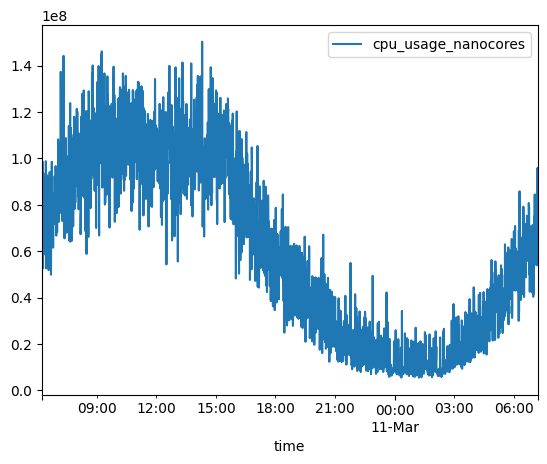

In [209]:
plot_cols = ['cpu_usage_nanocores']
plot_features = series_plot[plot_cols]
# plot_features.index = date_time
_ = plot_features.plot(subplots=True)

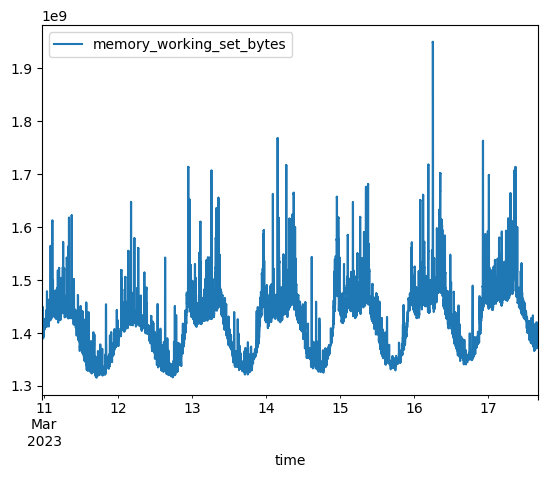

In [189]:
plot_cols = ['memory_working_set_bytes']
plot_features = series[plot_cols]
# plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [223]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(series)
scaled_values = scaled_values.reshape(len(scaled_values), 1)
series['memory_working_set_bytes'] = scaled_values
print(series)

# configure
n_lag = 1
n_seq = 4
n_test = 3860

                           memory_working_set_bytes
time                                               
2023-03-10 06:13:20+09:00                  0.022830
2023-03-10 06:13:50+09:00                  0.022830
2023-03-10 06:14:20+09:00                  0.022830
2023-03-10 06:14:50+09:00                  0.022830
2023-03-10 06:15:20+09:00                  0.021093
...                                             ...
2023-03-16 23:02:50+09:00                  0.139151
2023-03-16 23:03:20+09:00                  0.139056
2023-03-16 23:03:50+09:00                  0.139056
2023-03-16 23:04:20+09:00                  0.139080
2023-03-16 23:04:50+09:00                  0.139080

[19304 rows x 1 columns]


In [224]:

# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)

In [215]:
train.shape, test.shape

((15440, 5), (3860, 5))

In [225]:

# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)

In [226]:

# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)

t+1 RMSE: 0.010618
t+2 RMSE: 0.015202
t+3 RMSE: 0.018732
t+4 RMSE: 0.021717


In [31]:
len(forecasts[-300:])

300

In [83]:
a=np.array(forecasts)

In [91]:
a[0:1, -300:]

array([[0.50999038, 0.50999038, 0.50999038, 0.50999038]])

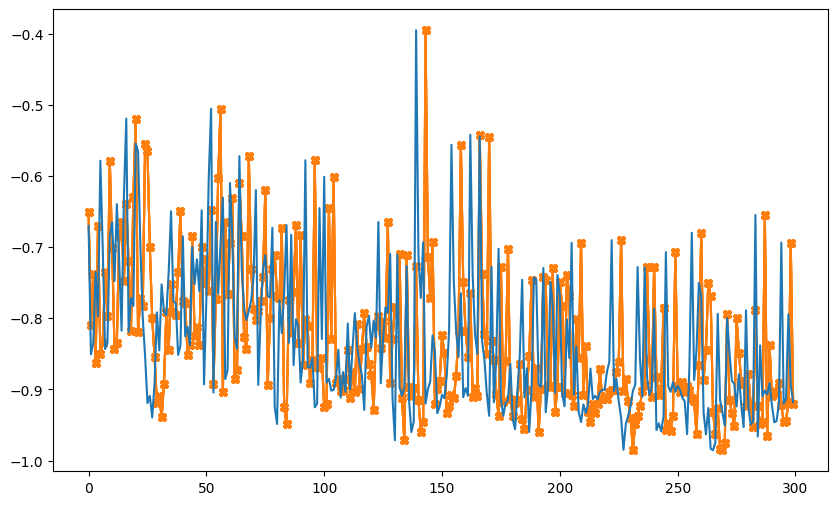

In [167]:
# pyplot.plot(series[15000:].values)
# 	# plot the forecasts in red
# for i in range(len(forecasts)):
#     off_s = len(series[15000:]) - n_test + i - 1
#     off_e = off_s + len(forecasts[i]) + 1
#     xaxis = [x for x in range(off_s, off_e)]
#     yaxis = [series[15000:].values[off_s]] + forecasts[i]
#     pyplot.plot(xaxis, yaxis, color='red')
# # show the plot
# pyplot.show()


pyplot.figure(figsize=(10,6)) 
pyplot.plot(forecasts[-300:],marker='X',c='#ff7f0e',
            label='Prediction')
pyplot.plot(series[-300:].to_numpy(),
            label='Inputs')
# plt.scatter(single_step_window.label_indices, train_predict[0, :, single_step_window.label_columns_indices.get('memory_working_set_bytes', None)],
#             marker='X', edgecolors='k', label='Predictions',
#             c='#ff7f0e', s=64)

pyplot.show() 

/opt/homebrew/anaconda3/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


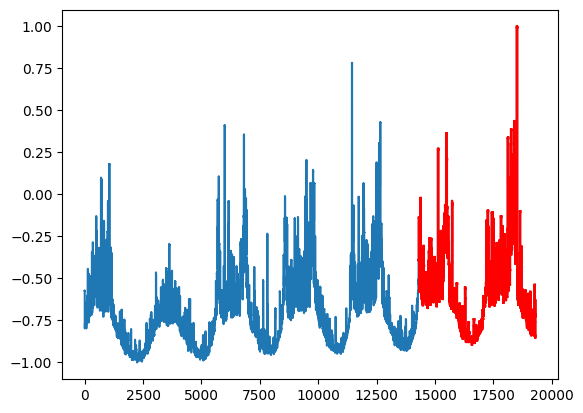

In [19]:

# plot forecasts
plot_forecasts(series, forecasts, n_test)